# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Are we using a GPU ?
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/datasets/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-05-04 07:57:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  27.4MB/s    in 6.6s    

2023-05-04 07:57:50 (24.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folders ?
import os

# Walktrough 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

# Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir =  "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/225.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size= BATCH_SIZE,
                                             class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model train)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback.
* Model checkpoint with the ModelCheckpoint callback.
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.



In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime, pytz

def create_tensorboard_callback(dir_name, experiment_name):
  # Create a log directory for storing TensorBoard logs
  tz = pytz.timezone("Europe/Paris")
  logdir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().astimezone(tz).strftime("%d%m%Y-%H%M%S")
  print(f"Saving TensorBoard log files to: {logdir}")
  return tf.keras.callbacks.TensorBoard(logdir)


🔑 **Note:** You can customize the directory where your TensorBoard Logs (model training metrics) get saved to whatever you like.
The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our owns models layer by layer from scratch. 

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1 

In [ ]:
# import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
# Let's compare the following two models 
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

inception_url = "https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5"

classifier_model = efficientnet_url #@param ["resnet_url", "efficientnet_url", "mobilenet_url", "inception_url"] {type:"raw"}

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(dir_name, experiment_name, model_url=classifier_model, num_classes=10, loss="categorical_crossentropy", activation="softmax", epochs=5):
  """
  Takes a TensorFlow Hub URL and creates a keras Sequential model with it.

    Args:
      model_url (str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons in the output layer.
      should be equal to number of target classes, default 10.
      dir_name (str): Name of the folder containing all tensorboard logs.
      experiment_name (str): Name of the folder containing tensorboard logs 
      corresponding to the pretrained model. 
      epochs (int): Number of iteration for all data.
      loss (str): Metrics for loss whether it is binary or multiclass .
      activation (str): Kind of outshape function whether it is binary or multiclass.
    
    Returns: 
      AN uncompiled Keras Sequential model with model_url as feature extractor 
      layer and Dense output layer with num_classes output neurons.
      A tensorflow history object.
  """
  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))  
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer, # Go through the pre-trained model first
      layers.Dense(num_classes, activation=activation, name="output_layer")
  ])

  # Compile our model
  model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
  # Fit our model (10 percent of 10 classes)
  tensorboard = create_tensorboard_callback(dir_name, experiment_name)
  history = model.fit(train_data,
                      epochs=epochs,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=[tensorboard])

  return model, history

### Creating and testing Resnet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model, history_1 = create_model(
                                       "drive/MyDrive/10_percent_food", 
                                       "resnet",
                                        num_classes=train_data.num_classes) # Number of classes

Saving TensorBoard log files to: drive/MyDrive/10_percent_food/resnet/04052023-095812
Epoch 1/5
17/24 [====================>.........] - ETA: 37s - loss: 2.2131 - accuracy: 0.2757

KeyboardInterrupt: ignored

In [ ]:
resnet_model.summary()

NameError: ignored

With all the data from previous course.

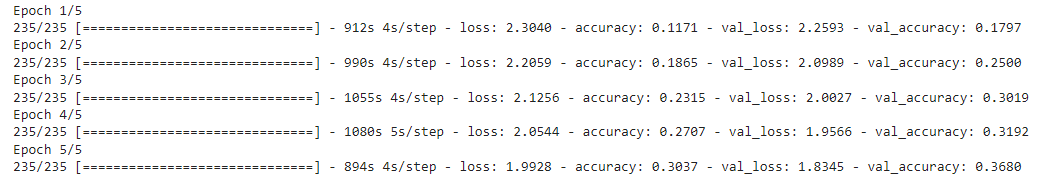

In the previous course we used all the data plus data augmentation and the accuracy is half the value of 10% of the data not augmented with transfer learning extractor model. 

In [ ]:
# Let's create a function to plot our loss curves...
!git clone https://github.com/JoachimLombardi/Helper_functions.git
from Helper_functions.plot_loss_curves import plot_loss_curves

Cloning into 'Helper_functions'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 21 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), 5.32 KiB | 907.00 KiB/s, done.


In [ ]:
plot_loss_curves(history_1)

### Creating and testing efficientnetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create efficientnetB0 model -- details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model, history_2 = create_model(
                                             "drive/MyDrive/10_percent_food", 
                                             "efficientnet",
                                              num_classes=train_data.num_classes) # Number of classes                                     

In [ ]:
plot_loss_curves(history_2)

## Saving and reloading a trained model

In [ ]:
import os, datetime, pytz
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  tz = pytz.timezone('Europe/Paris')
  modeldir = os.path.join("/content/drive/MyDrive/10_percent_food/save",
                          datetime.datetime.now().astimezone(tz).strftime("%d%m%Y-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # Save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
import tensorflow_hub as hub
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                      custom_objects={"KerasLayer":hub.KerasLayer}) # first layer
  return model

In [ ]:
save_model(resnet_model, "resnet_model"),
save_model(efficientnet_model, "efficientnet_model")

In [ ]:
efficientnet_model.summary()

In [ ]:
# How many layers does our efficientb0 feature extractor have ?
len(efficientnet_model.layers[0].weights)

In [ ]:
# Let's checkout another way of viewing our deep learning model
from tensorflow.keras.utils import plot_model
plot_model(efficientnet_model, show_shapes=True)

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes whatsoever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers).

## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./drive/MyDrive/10_percent_food/ \
--name "EfficientNetB0 vs ResNet50V2" \
--description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
--one_shot

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/fwHeOkKNQL6N9ZepWWgjUw/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id fwHeOkKNQL6N9ZepWWgjUw

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

### 🛠 04. Transfer Learning in TensorFlow Part 1: Feature Extraction Exercises

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([`mobilenet_v2_100_224/feature_vector`](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) from TensorFlow Hub, how does it perform compared to our other models?
2. Name 3 different image classification models on TensorFlow Hub that we haven't used.
3. Build a model to classify images of two different things you've taken photos of.
  * You can use any feature extraction layer from TensorFlow Hub you like for this.
  * You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.
4. What is the current best performing model on ImageNet?
  * Hint: you might want to check [sotabench.com](https://www.sotabench.com) for this.

In [ ]:
mobilenet_model, history_3 = create_model(
                                     "/content/drive/MyDrive/10_percent_food",
                                     "mobile_net",
                                     10)

Saving TensorBoard log files to: /content/drive/MyDrive/10_percent_food/mobile_net/04052023-100600
Epoch 1/5
24/24 [==============================] - 183s 8s/step - loss: 1.9360 - accuracy: 0.3547 - val_loss: 1.2840 - val_accuracy: 0.6244
Epoch 2/5
24/24 [==============================] - 175s 8s/step - loss: 1.0315 - accuracy: 0.7147 - val_loss: 0.8900 - val_accuracy: 0.7524
Epoch 3/5
24/24 [==============================] - 180s 8s/step - loss: 0.7322 - accuracy: 0.8187 - val_loss: 0.7442 - val_accuracy: 0.7880
Epoch 4/5
24/24 [==============================] - 164s 7s/step - loss: 0.5740 - accuracy: 0.8587 - val_loss: 0.6828 - val_accuracy: 0.7972
Epoch 5/5
24/24 [==============================] - 155s 7s/step - loss: 0.4803 - accuracy: 0.8880 - val_loss: 0.6420 - val_accuracy: 0.8008


In [ ]:
save_model(mobile_net, "mobile_net")

Saving model to: /content/drive/MyDrive/10_percent_food/save/04052023-102056-mobile_net.h5...


'/content/drive/MyDrive/10_percent_food/save/04052023-102056-mobile_net.h5'

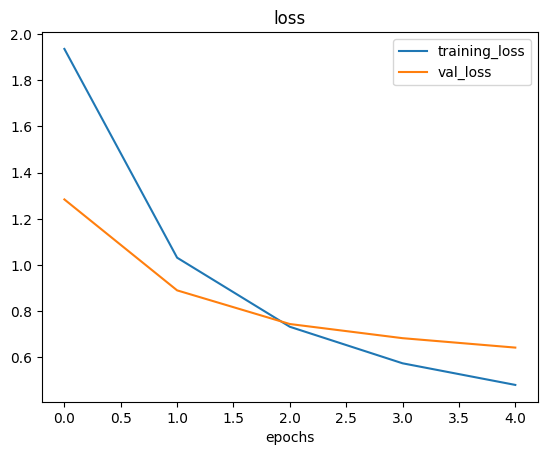

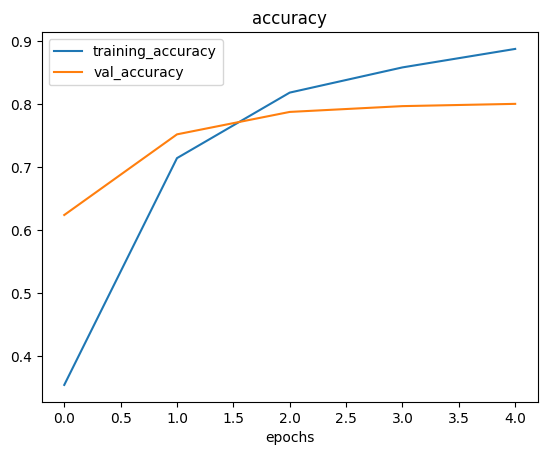

In [ ]:
plot_loss_curves(history_3)

Here are 3 different image classification models on TensorFlow Hub that we haven't use:
nasnet, inception, mobilevit

In [ ]:
train_dir = "drive/MyDrive/trees/train"
test_dir =  "drive/MyDrive/trees/test"
custom_dir = "drive/MyDrive/trees/custom"

train_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/225.)

custom_datagen = ImageDataGenerator(rescale=1/225.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size= BATCH_SIZE,
                                             class_mode="binary",
                                             shuffle=False)

print("Custom images:")
custom_data = test_datagen.flow_from_directory(custom_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size= BATCH_SIZE,
                                             class_mode="binary",
                                             shuffle=False)

Training images:
Found 20 images belonging to 2 classes.
Testing images:
Found 10 images belonging to 2 classes.
Custom images:
Found 7 images belonging to 2 classes.


In [ ]:
# We create the model with efficientnet
efficientnet_model_for_tree, history_4 = create_model(
                                                      "drive/MyDrive/trees",
                                                      "efficientnet",
                                                      num_classes=1,
                                                      loss="binary_crossentropy",
                                                      activation="sigmoid",
                                                      epochs=10)

Saving TensorBoard log files to: drive/MyDrive/trees/efficientnet/04052023-170203
Epoch 1/10
1/1 [==============================] - 23s 23s/step - loss: 0.6841 - accuracy: 0.7000 - val_loss: 0.6020 - val_accuracy: 0.7000
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.6394 - accuracy: 0.7000 - val_loss: 0.5640 - val_accuracy: 0.7000
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.5970 - accuracy: 0.7500 - val_loss: 0.5287 - val_accuracy: 0.7000
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.5570 - accuracy: 0.8000 - val_loss: 0.4961 - val_accuracy: 0.8000
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.5195 - accuracy: 0.8000 - val_loss: 0.4661 - val_accuracy: 0.8000
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.4845 - accuracy: 0.8500 - val_loss: 0.4385 - val_accuracy: 0.9000
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.4517 - accuracy: 0.9000

In [ ]:
efficientnet_model_for_tree.evaluate(test_data)

1/1 [==============================] - 1s 1s/step - loss: 0.3640 - accuracy: 1.0000


[0.363983690738678, 1.0]

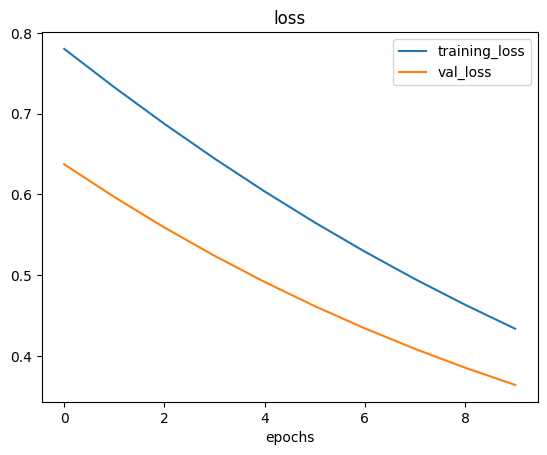

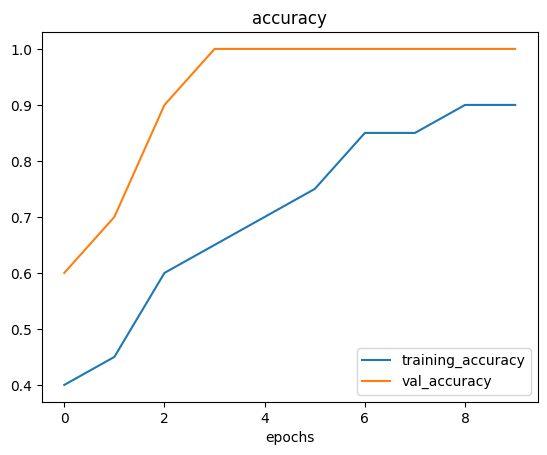

In [ ]:
plot_loss_curves(history_4)

In [ ]:
# We create the model with inception
inception_model_for_tree, history_5 = create_model(inception_url,
                                                   "drive/MyDrive/trees",
                                                   "inception",
                                                   1,
                                                   "binary_crossentropy",
                                                   "sigmoid",
                                                   10)

Saving TensorBoard log files to: drive/MyDrive/trees/inception/04052023-104116
Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 0.9625 - accuracy: 0.5000 - val_loss: 0.7270 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.8850 - accuracy: 0.4500 - val_loss: 0.6810 - val_accuracy: 0.7000
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.8243 - accuracy: 0.4000 - val_loss: 0.6514 - val_accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.7795 - accuracy: 0.3500 - val_loss: 0.6349 - val_accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.7480 - accuracy: 0.3500 - val_loss: 0.6275 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.7262 - accuracy: 0.5000 - val_loss: 0.6248 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.7102 - accuracy: 0.5000 - 

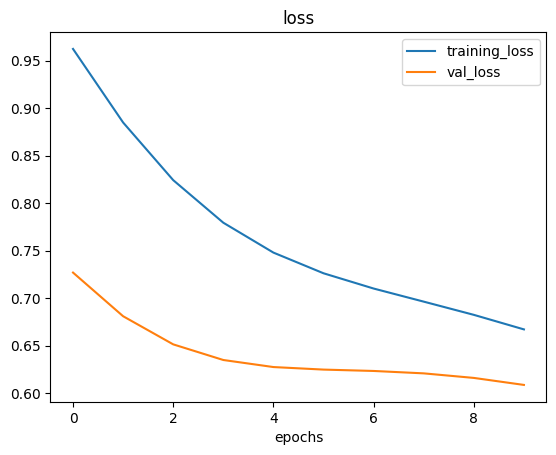

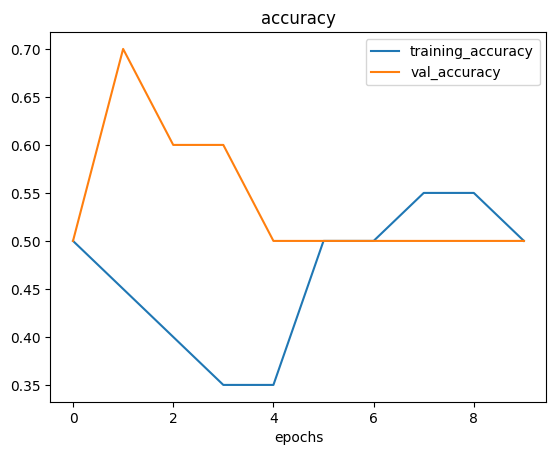

In [ ]:
plot_loss_curves(history_5)

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./drive/MyDrive/trees \
--name "EfficientNetB0 vs inception_v1" \
--description "Comparing two different TF Hub feature extraction model architectures using 10 images" \
--one_shot

2023-05-04 08:43:12.130336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./drive/MyDrive/trees

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   MNB-NND-LWG



New experiment created. View your TensorBoard at: https://tensorboard.de

In [ ]:
# Visualize data
import matplotlib.pyplot as plt
import random
# Create a function for viewing images in a data batch
def show_batches_images(images, labels, augmented_images=None, augmented_label=None):
  """
  Displays a plot of random images and their labels from a data batch.
  """
  i = random.choice(range(len(images)))
  j = random.choice(range(len(images)))
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Create subplots (5 rows, 5 columns)
  plt.subplot(1, 2, 1)
  # Display an image
  plt.imshow(images[i])
  print("Showing image number:{}".format(i))
  # Add the image label as the title
  if labels.ndim == 1:
    plt.title(class_names[int(tf.round(labels[i]))])
  else:
    plt.title(class_names[labels[i].argmax()])
  # Turn the grid lines off
  plt.axis("off")
  # Create subplots (5 rows, 5 columns)
  plt.subplot(1, 2, 2)
  # Display an image
  plt.imshow(images[j])
  print("Showing image number:{}".format(j))
  # Add the image label as the title
  if labels.ndim == 1:
    plt.title(class_names[int(tf.round(labels[j]))])
  else:
    plt.title(class_names[labels[j].argmax()])
  # Turn the grid lines off
  plt.axis("off")

  if (augmented_images is not None):
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Create subplots (5 rows, 5 columns)
    plt.subplot(1, 2, 1)
    # Display an image
    plt.imshow(augmented_images[i])
    print("Showing augmented image number:{}".format(i))
    # Add the image label as the title
    if labels.ndim == 1:
      plt.title(class_names[int(tf.round(augmented_labels[i]))])
    else:
      plt.title(class_names[augmented_labels[i].argmax()])
      # Turn the grid lines off
      plt.axis("off")
      # Create subplots (5 rows, 5 columns)
      plt.subplot(1, 2, 2)
      # Display an image
      plt.imshow(augmented_images[j])
      print("Showing augmented image number:{}".format(j))
      # Add the image label as the title
    if labels.ndim == 1:
      plt.title(class_names[int(tf.round(augmented_labels[j]))])
    else:
      plt.title(class_names[augmented_labels[j].argmax()])
      # Turn the grid lines off
      plt.axis("off")

In [ ]:
# Unbatch train_data
images, labels = train_data.next()

In [ ]:
labels[17]

0.0

In [ ]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['palmiers' 'sapins']


Showing image number:17
Showing image number:11


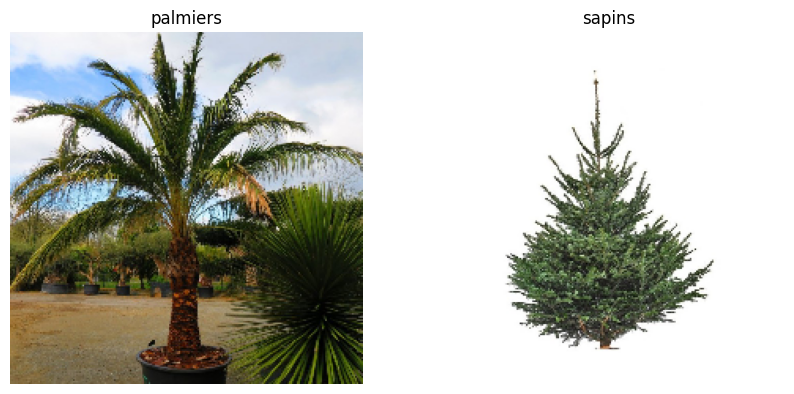

In [ ]:
show_batches_images(images, labels)

In [ ]:
len(test_data)

1

In [ ]:
tf.round(predictions_tree)[:,0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 1., 1., 1., 0., 1.], dtype=float32)>

In [ ]:
# Unbatch test_data
image, label = test_data.next() 

In [ ]:
# Faire une prediction pour le model efficientnet
predictions_tree = efficientnet_model_for_tree.predict(image)

1/1 [==============================] - 1s 1s/step


In [ ]:
label

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)

In [ ]:
tf.round(predictions_tree)[:,0] == label

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])>

In [ ]:
image

array([[[[0.4888889 , 0.74222225, 1.0488889 ],
         [0.4888889 , 0.74222225, 1.0488889 ],
         [0.4888889 , 0.74222225, 1.0488889 ],
         ...,
         [0.4488889 , 0.6977778 , 1.0400001 ],
         [0.4488889 , 0.6977778 , 1.0400001 ],
         [0.4488889 , 0.6977778 , 1.0400001 ]],

        [[0.4888889 , 0.74222225, 1.0488889 ],
         [0.4888889 , 0.74222225, 1.0488889 ],
         [0.4888889 , 0.74222225, 1.0488889 ],
         ...,
         [0.4488889 , 0.6977778 , 1.0400001 ],
         [0.4488889 , 0.6977778 , 1.0400001 ],
         [0.4488889 , 0.6977778 , 1.0400001 ]],

        [[0.4888889 , 0.74222225, 1.0488889 ],
         [0.4888889 , 0.74222225, 1.0488889 ],
         [0.4888889 , 0.74222225, 1.0488889 ],
         ...,
         [0.4488889 , 0.6977778 , 1.0400001 ],
         [0.4577778 , 0.7066667 , 1.0488889 ],
         [0.4577778 , 0.7066667 , 1.0488889 ]],

        ...,

        [[0.8177778 , 0.82222223, 0.76      ],
         [0.73333335, 0.73777777, 0.6755556 ]

Showing image number:8
Showing image number:9


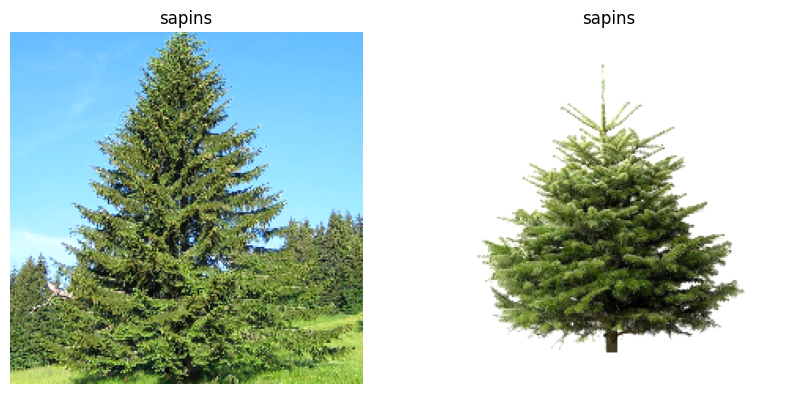

In [ ]:
show_batches_images(image, predictions_tree[:, 0])

In [ ]:
# Trying with custom data
# Unbatch test_data
image_cust, label_cust = custom_data.next() 
# Faire une prediction pour le model efficientnet
predictions_cust_tree = efficientnet_model_for_tree.predict(image_cust)

1/1 [==============================] - 0s 449ms/step


In [ ]:
predictions_cust_tree

array([[0.43825668],
       [0.18979968],
       [0.54900223],
       [0.25577047],
       [0.60362035],
       [0.48897624]], dtype=float32)

In [ ]:
label_cust

array([0., 0., 0., 1., 1., 1.], dtype=float32)

In [ ]:
tf.round(predictions_cust_tree)[:,0] == label_cust

<tf.Tensor: shape=(7,), dtype=bool, numpy=array([ True,  True, False, False, False,  True, False])>

Showing image number:2
Showing image number:0


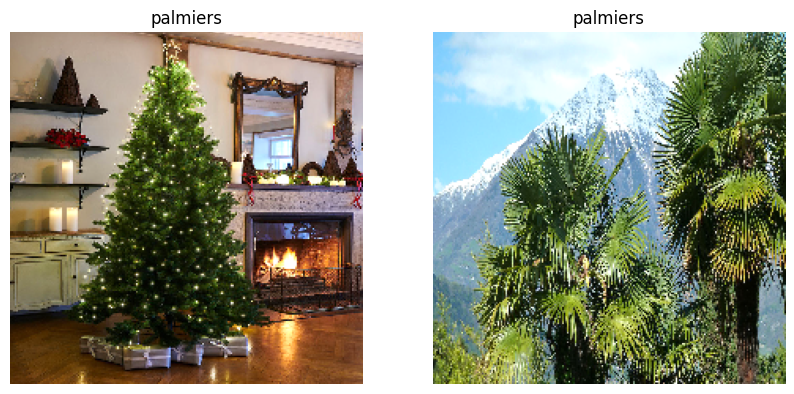

In [ ]:
show_batches_images(image_cust, predictions_cust_tree[:, 0])

### 📖 04. Transfer Learning in TensorFlow Part 1: Feature Extraction Extra-curriculum

* Read through the [TensorFlow Transfer Learning Guide](https://www.tensorflow.org/tutorials/images/transfer_learning) and define the main two types of transfer learning in your own words.
* Go through the [Transfer Learning with TensorFlow Hub tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) on the TensorFlow website and rewrite all of the code yourself into a new Google Colab notebook making comments about what each step does along the way.
* We haven't covered fine-tuning with TensorFlow Hub in this notebook, but if you'd like to know more, go through the [fine-tuning a TensorFlow Hub model tutorial](https://www.tensorflow.org/hub/tf2_saved_model#fine-tuning) on the TensorFlow homepage.How to fine-tune a tensorflow hub model:  
* Look into [experiment tracking with Weights & Biases](https://www.wandb.com/experiment-tracking), how could you integrate it with our existing TensorBoard logs?